In [1]:
pip install opencv-python

In [2]:
pip install tqdm


In [3]:
pip install seaborn

In [4]:
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
%matplotlib inline 

In [5]:
TEST_SIZE = 0.5
RANDOM_STATE = 2020
BATCH_SIZE = 64
NO_EPOCHS = 10
NUM_CLASSES = 2
IMG_SIZE = 75


In [13]:
train_image_list = os.listdir("/content/drive/MyDrive/Cats_Dogs/Cats_Dogs/train")

In [14]:
train_data = np.load('/content/drive/MyDrive/train_data.npy',allow_pickle=True)
test_data = np.load('/content/drive/MyDrive/test_data.npy',allow_pickle=True)


In [8]:
def label_img(img):
    word_label = img.split('.')[-3]
    # DIY One hot encoder
    if word_label == 'cat': return [1, 0]
    elif word_label == 'dog': return [0, 1]

In [11]:
!unzip /content/drive/MyDrive/Cats_Dogs.zip -d /content/drive/MyDrive/Cats_Dogs

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Cats_Dogs/Cats_Dogs/train/dog.5499.jpg  
  inflating: /content/drive/MyDrive/Cats_Dogs/Cats_Dogs/train/dog.55.jpg  
  inflating: /content/drive/MyDrive/Cats_Dogs/Cats_Dogs/train/dog.550.jpg  
  inflating: /content/drive/MyDrive/Cats_Dogs/Cats_Dogs/train/dog.5500.jpg  
  inflating: /content/drive/MyDrive/Cats_Dogs/Cats_Dogs/train/dog.5501.jpg  
  inflating: /content/drive/MyDrive/Cats_Dogs/Cats_Dogs/train/dog.5502.jpg  
  inflating: /content/drive/MyDrive/Cats_Dogs/Cats_Dogs/train/dog.5503.jpg  
  inflating: /content/drive/MyDrive/Cats_Dogs/Cats_Dogs/train/dog.5504.jpg  
  inflating: /content/drive/MyDrive/Cats_Dogs/Cats_Dogs/train/dog.5505.jpg  
  inflating: /content/drive/MyDrive/Cats_Dogs/Cats_Dogs/train/dog.5506.jpg  
  inflating: /content/drive/MyDrive/Cats_Dogs/Cats_Dogs/train/dog.5507.jpg  
  inflating: /content/drive/MyDrive/Cats_Dogs/Cats_Dogs/train/dog.5508.jpg  
  inflating: /content/drive/

In [ ]:
def create_train_data():
    # Creating an empty list where we should store the training data
    # after a little preprocessing of the data
    training_data = []
 
    # tqdm is only used for interactive loading
    # loading the training data
    for img in tqdm(os.listdir('/content/drive/MyDrive/Cats-Dogs/Cats_Dogs/train/')):
 
        # labeling the images
        label = label_img(img)
 
        path = os.path.join('/content/drive/MyDrive/Cats-Dogs/Cats_Dogs/train/', img)
 
        # loading the image from the path and then converting them into
        # grayscale for easier covnet prob
        img = cv2.imread(path ,-1)
 
        # resizing the image for processing them in the covnet
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
 
        # final step-forming the training data list with numpy array of the images
        training_data.append([np.array(img), np.array(label)])
 
    # shuffling of the training data to preserve the random state of our data
    shuffle(training_data)
 
    # saving our trained data for further uses if required
    np.save('train_data.npy', training_data)
    return training_data

In [ ]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir('/content/drive/MyDrive/Cats-Dogs/Cats_Dogs/test1/')):
        path = os.path.join('/content/drive/MyDrive/Cats-Dogs/Cats_Dogs/test1/', img)
        img_num = img.split('.')[0]
        img = cv2.imread(path ,-1)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
         
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


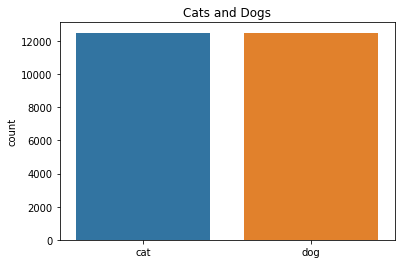

In [15]:
def plot_image_list_count(data_image_list):
    labels = []
    for img in data_image_list:
        labels.append(img.split('.')[-3])
    sns.countplot(labels)
    plt.title('Cats and Dogs')
    
plot_image_list_count(train_image_list)

In [ ]:
train_data = create_train_data()
test_data = process_test_data()

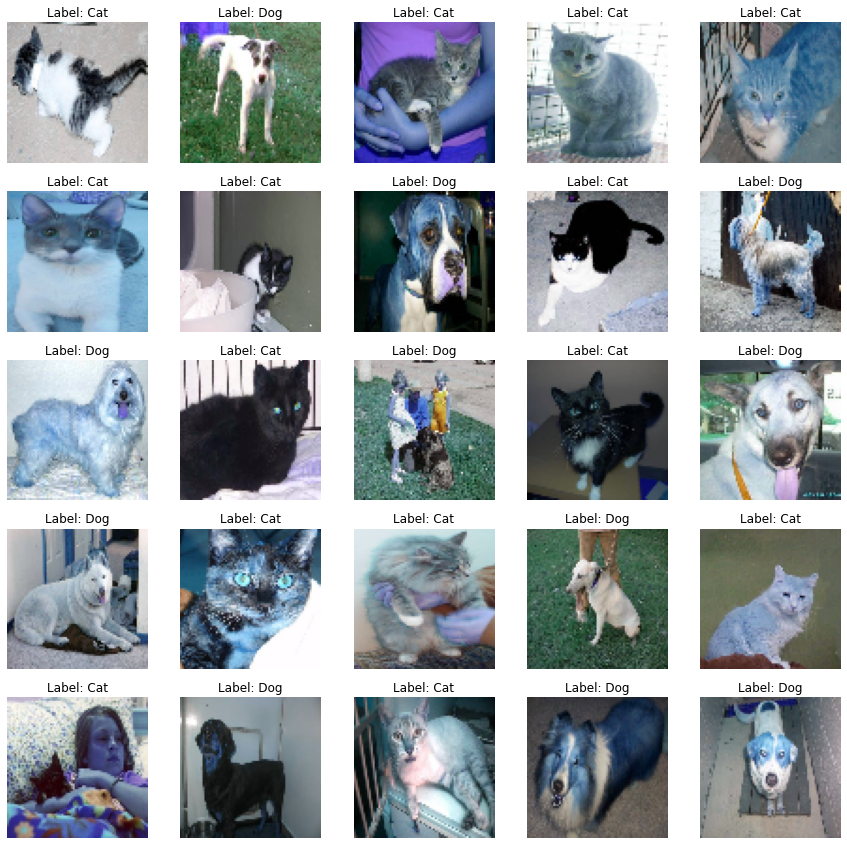

In [16]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 1: 
            str_label='Dog'
        elif label == 0: 
            str_label='Cat'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

show_images(train_data)

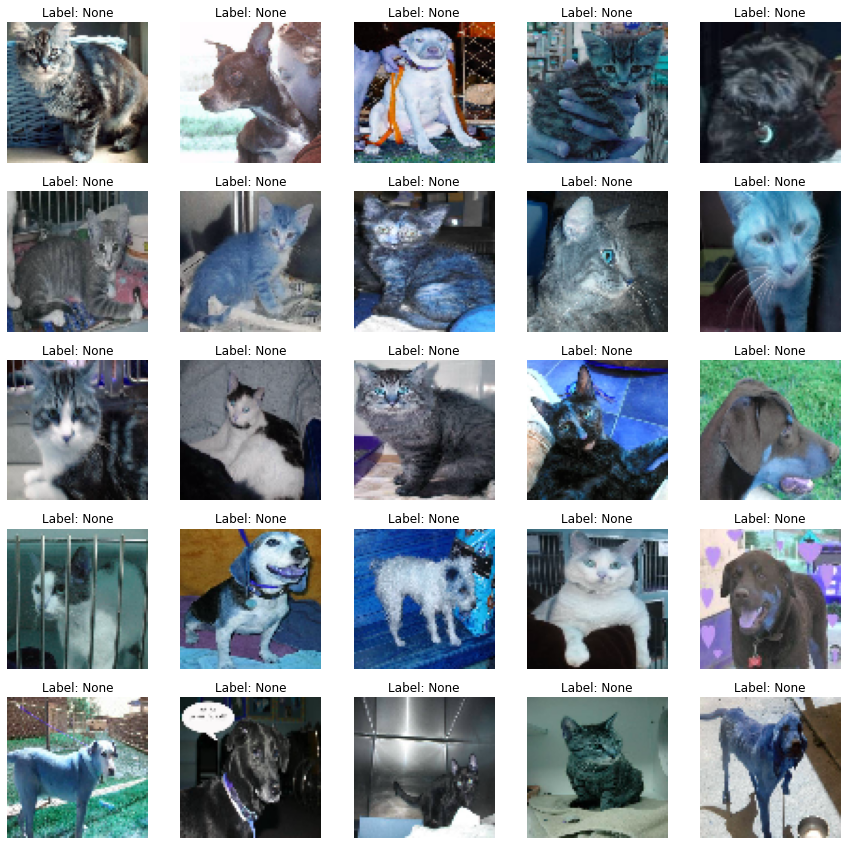

In [17]:
show_images(test_data,True)

In [18]:
X = np.array([i[0] for i in train_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train_data])

In [19]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True

94781440/94765736 [==============================] - 2s 0us/step


In [20]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [23]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/10
196/196 [==============================] - 46s 147ms/step - loss: 0.8568 - accuracy: 0.8434 - val_loss: 0.4142 - val_accuracy: 0.8766
Epoch 2/10
196/196 [==============================] - 27s 139ms/step - loss: 0.0893 - accuracy: 0.9686 - val_loss: 0.2832 - val_accuracy: 0.8993
Epoch 3/10
196/196 [==============================] - 28s 142ms/step - loss: 0.0202 - accuracy: 0.9958 - val_loss: 0.2938 - val_accuracy: 0.9072
Epoch 4/10
196/196 [==============================] - 28s 145ms/step - loss: 0.0085 - accuracy: 0.9984 - val_loss: 0.3072 - val_accuracy: 0.9078
Epoch 5/10
196/196 [==============================] - 28s 144ms/step - loss: 0.0050 - accuracy: 0.9994 - val_loss: 0.3130 - val_accuracy: 0.9126
Epoch 6/10
196/196 [==============================] - 28s 144ms/step - loss: 0.0039 - accuracy: 0.9994 - val_loss: 0.3339 - val_accuracy: 0.9106
Epoch 7/10
196/196 [==============================] - 28s 145ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.4052 - val_ac

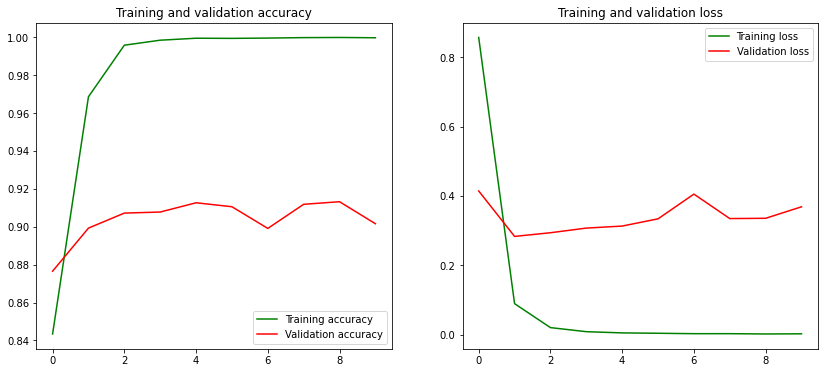

In [24]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

In [25]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.3685838580131531
Validation accuracy: 0.9016000032424927


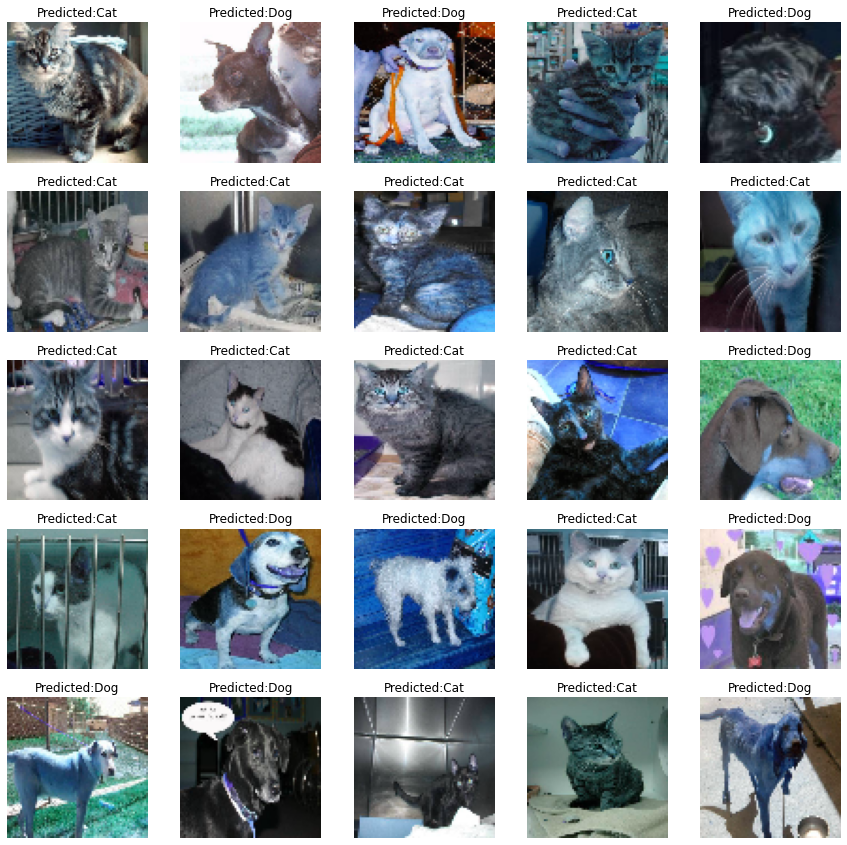

In [26]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test_data[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()

In [27]:
pred_list = []
img_list = []
for img in tqdm(test_data):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    predicted = (model.predict([data])[0])
    img_list.append(img_idx)
    pred_list.append(round(predicted[1]))

100%|██████████| 12500/12500 [10:41<00:00, 19.49it/s]


In [30]:
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission_resnet50_img75.csv", index=False)